# Howso Enterprise Data Synthesis Workflow

This notebook will provide a high level overview of the synthetic data generation process, including the final data evaluation for accuracy vs. privacy trade off. More details on each data generation step will be covered in subsequent notebooks.

The process can be broken down into six key steps as illustrated in the diagram below.

<img src="static/synthesizer_process_workflow.png" width="1080">

## Step 1: Load Data

In [1]:
from pathlib import Path

from IPython.display import (
    display,
    Markdown,
)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from howso.enterprise import Howso, infer_feature_attributes

In [2]:
data_path = Path("data", "radx", "rad_015_941-01_qPCR_ProcessedData_DATA_origcopy_v1.csv")
df = pd.read_csv(data_path)
df = df.reset_index(drop=True)

print(df.columns)

Index(['sample_id', 'pcr_target', 'sars_cov2_avg_conc', 'sars_cov2_units',
       'hum_frac_target_mic', 'hum_frac_mic_conc', 'hum_frac_mic_unit',
       'other_norm_name', 'other_norm_conc', 'other_norm_unit',
       'inhibition_detect'],
      dtype='object')


## Step 2: Map Data

Confirm the data types are detected correctly.


In [3]:
features = infer_feature_attributes(df)

# As this is just a recipe notebook and not an attempt at creating anonymous data, we are setting the nominal features
# as `non_sensitive`. When creating anonymous data, you should only set nominal features as non-sensitive if they are
# truly non-sensitive. For example, when attempting to create anonymous data, we strongly recommend that nominals are
# encoded, which can be achieved by the following utility code:
# features = infer_features_attributes(df_orig, attempt_infer_extended_nominals=True)
for feature_name in features.get_names(types=("nominal", "ordinal")):
    features[feature_name]["non_sensitive"] = True

features.to_dataframe()

type decimal_places     bounds                     \
                                               allow_null  min           max   
sample_id               nominal            NaN       True  NaN           NaN   
pcr_target              nominal            NaN       True  NaN           NaN   
sars_cov2_avg_conc   continuous            2.0       True  0.0  5.843472e+07   
sars_cov2_units         nominal            NaN       True  NaN           NaN   
hum_frac_target_mic     nominal            NaN       True  NaN           NaN   
hum_frac_mic_conc    continuous            2.0       True  0.0  6.520107e+10   
hum_frac_mic_unit       nominal            NaN       True  NaN           NaN   
other_norm_name         nominal            NaN       True  NaN           NaN   
other_norm_conc      continuous            2.0       True  0.0  2.668245e+07   
other_norm_unit         nominal            NaN       True  NaN           NaN   
inhibition_detect       nominal            NaN       True  NaN           NaN   

                                               data_type non_sensitive  \
                    observed_min  observed_max                           
sample_id                    NaN           NaN       NaN          True   
pcr_target                   NaN           NaN       NaN          True   
sars_cov2_avg_conc           0.0  3.544245e+07    number           NaN   
sars_cov2_units              NaN           NaN       NaN          True   
hum_frac_target_mic          NaN           NaN       NaN          True   
hum_frac_mic_conc            0.0  3.954645e+10    number           NaN   
hum_frac_mic_unit            NaN           NaN       NaN          True   
other_norm_name              NaN           NaN       NaN          True   
other_norm_conc              0.0  1.618372e+07    number           NaN   
other_norm_unit              NaN           NaN       NaN          True   
inhibition_detect            NaN           NaN       NaN          True   

                    original_type       
                        data_type size  
sample_id                  string  NaN  
pcr_target                 string  NaN  
sars_cov2_avg_conc        numeric  8.0  
sars_cov2_units            string  NaN  
hum_frac_target_mic        string  NaN  
hum_frac_mic_conc         numeric  8.0  
hum_frac_mic_unit          string  NaN  
other_norm_name            string  NaN  
other_norm_conc           numeric  8.0  
other_norm_unit            string  NaN  
inhibition_detect          string  NaN

## Step 3: Set Desired Parameters

- Desired parameter: Synthesizer allows the user to tune synthetic data based on privacy / accuracy requirements, this notebook will use the default settings which provides a good balance between accuracy and privacy


## Step 4-6: Characterize Data, Generate New Data, Analyze Data

> ⚠ Note: To parameterize synthesis using epsilon (differential privacy), use the `epsilon_upper_bound` parameter to `Howso.synthesize()`
> instead of `desired_conviction`. Validator's `AnonymityPreservation` measures epsilon post-synthesis by accessing the average distance between each synthetic point and its nearest original record, which may be used to validate that the empirical epsilon is below `epsilon_upper_bound`.

- Characterize Data: Synthesizer preserves the distribution in the original dataset by default and cross-shreds the original data so there will not be a 1-to-1 mapping to the original dataset to maintain privacy. 

- Analyze Data: Validator uses the same Trainee as Synthesizer to analyze the quality _and_ privacy of the synthesis.

- Characterizing, generating, and analyzing new synthetic data with Synthesizer & Validator using the parameters described above is as simple as:


In [4]:
with Howso() as howso:
    print(howso.synthesize.__doc__)


        Synthesize the given ``source_file_name`` into ``destination_file_name``.

        if a ``chunk_size`` is specified, split up the source file into
        "chunks" of ``chunk_size`` samples and process them through Synthesizer
        as independent data frames, but return all synthetic results together
        in the destination file. The aim is to "divide and conquer" very large
        data sources to be processed across multiple workers on multiple other
        compute nodes.

        Parameters
        ----------
        source_data : str or Path or AbstractData
            The source data.
        features : Dictionary or FeatureAttributesBase
            Feature attributes. Please see ``howso.synthesizer.train()``
            documentation for further details. If this is supplied,
            feature_attribute_overrides is ignored.

        chunk_size : int, optional
            The desired size of each chunk. The larger the better for accuracy and
            privacy.

In [5]:
tests_to_run = [
    "AnonymityPreservation",
    "DescriptiveStatistics",
    "JointProbability",
    "ModelComparison",
    # FeatureImportanceComparison is expensive and you should consider disabling it for large datasets,
    # particularly datasets with many features.
    "FeatureImportanceComparison",
]

# Instantiate our compute environment. In this case it is Howso Standalone running on a local machine.
with Howso() as howso:
    results = howso.synthesize(
        # Perform the synthesis, with validation
        source_data=df,
        features=features,
        validate_options={"metrics": tests_to_run},
        destination_data='radx_synthesized_data_qPCR.csv'
    )

display(results.destination_data.get_dataframe())


Version 45.0.0 of Howso Engine™ is available. You are using version 39.0.0.


Train chunk «radx_synthesized_data_qpcr:chunk-1» with 2,351 samples took 0:00:00.441665.
Analyze chunk «radx_synthesized_data_qpcr:chunk-1» with 2,351 samples took 0:00:02.441045.
Synthesize chunk «radx_synthesized_data_qpcr:chunk-1» with 2,351 samples took 0:00:08.950821.
Validate chunk «radx_synthesized_data_qpcr:chunk-1» with 2,351 samples took 0:03:12.231577.
Validator desirability results of chunk «radx_synthesized_data_qpcr:chunk-1»: AnonymityPreservation: 5.0 | DescriptiveStatistics: 0.678 | JointProbability: 4.339 | ModelComparison: 4.156 | FeatureImportanceComparison: 1.523
Processing complete.
Synthesizing DataFrameData8726645126794 to radx_synthesized_data_qPCR.csv via chunks of 25,000 samples with 1 workers required 0:03:24.821159.
Wall clock: 0:03:24.821159 (100.4%), Train: 0:00:00.441665 (0.2%), 
Analyze: 0:00:02.441045 (1.2%), 
Synthesis: 0:00:08.950821 (4.4%), 
Validation: 0:03:12.231577 (94.2%), Total CPU: 0:03:24.065108.


,sample_id,pcr_target,sars_cov2_avg_conc,sars_cov2_units,hum_frac_target_mic,hum_frac_mic_conc,hum_frac_mic_unit,other_norm_name,other_norm_conc,other_norm_unit,inhibition_detect
0,WSAC-220621,n,4362.81,copies/L wastewater,pepper mild mottle virus,NaN,NaN,qB2M,NaN,NaN,Not tested
1,WSNB-221115,n,0.00,NaN,pepper mild mottle virus,NaN,NaN,qB2M,87571.52,copies/L wastewater,Not tested
2,WG0P-210817,n,3451.95,copies/L wastewater,pepper mild mottle virus,1.796511e+10,copies/L wastewater,qB2M,3221867.95,copies/L wastewater,Not tested
3,WG0W-211102,n,0.00,NaN,pepper mild mottle virus,8.274900e+06,copies/L wastewater,qB2M,22714.31,copies/L wastewater,Not tested
4,WM08-210720,n,0.00,NaN,pepper mild mottle virus,2.629636e+08,copies/L wastewater,qB2M,181743.53,copies/L wastewater,Not tested
...,...,...,...,...,...,...,...,...,...,...,...
2346,WSNS-220830,n,842.00,copies/L wastewater,pepper mild mottle virus,6.638179e+07,copies/L wastewater,qB2M,271359.02,copies/L wastewater,Not tested
2347,WG02g-210427,n,0.00,NaN,pepper mild mottle virus,1.250523e+08,copies/L wastewater,qB2M,281376.64,copies/L wastewater,Not tested
2348,WG0A-210622,n,0.00,NaN,pepper mild mottle virus,4.420366e+07,copies/L wastewater,qB2M,566884.33,copies/L wastewater,Not tested
2349,WG0U-220817,n,0.03,NaN,pepper mild mottle virus,NaN,NaN,qB2M,126133.74,copies/L wastewater,Not tested


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,38,management,single,tertiary,no,7865,yes,no,cellular,20,nov,321,1,175,2,failure,no
1,23,management,single,tertiary,no,2681,yes,no,cellular,4,aug,202,2,458,1,success,yes
2,56,retired,single,primary,no,4113,no,no,cellular,13,dec,194,1,-1,0,unknown,no
3,27,blue-collar,married,secondary,no,3,no,yes,cellular,4,may,488,7,-1,0,unknown,yes
4,27,blue-collar,married,primary,no,276,yes,no,unknown,8,may,203,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,36,management,single,tertiary,no,66,no,no,cellular,26,aug,111,11,-1,0,unknown,no
4517,27,management,married,tertiary,no,1772,no,no,unknown,1,jun,543,1,-1,0,unknown,no
4518,32,technician,married,secondary,no,2167,yes,yes,unknown,6,may,572,2,-1,0,unknown,yes
4519,32,blue-collar,married,primary,no,362,yes,yes,cellular,20,apr,102,2,-1,0,unknown,no


### Step 6.1: Inspect results

For the data set we will do a simple visual comparison and calculate the descriptive statistics along with classification accuracy between the original vs. the synthesized data to determine the quality of synthesis

Index(['sars_cov2_avg_conc', 'hum_frac_mic_conc', 'other_norm_conc'], dtype='object')


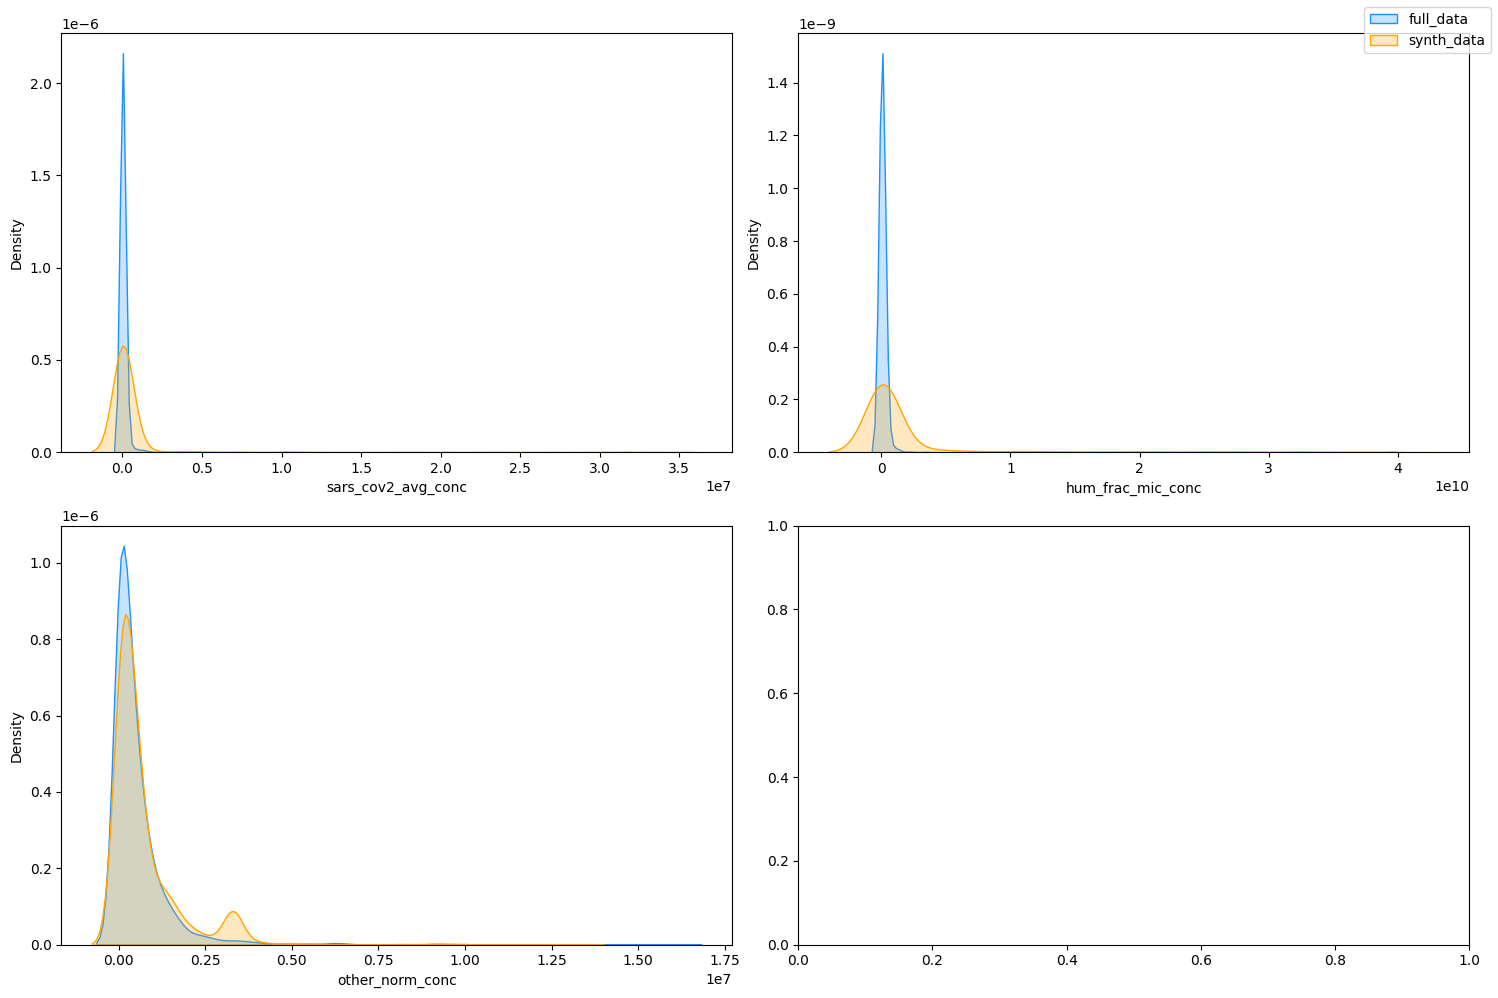

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
categorical_features = [f for f, a in features.items() if a["type"] in ("nominal", "ordinal")]
print(df.columns.drop(categorical_features))
for c, ax in zip(df.columns.drop(categorical_features), axes.flat):
    sns.kdeplot(ax=ax, x=df[c], color="dodgerblue", label="full_data", fill=True)
    sns.kdeplot(ax=ax, x=results.destination_data.get_dataframe()[c], color="orange", label="synth_data", fill=True)
    ax.set_xlabel(c)

fig.legend(labels=["full_data", "synth_data"])
fig.tight_layout()
plt.show()

In [7]:
for name, result in sorted(results.validate_results.items()):
    display(Markdown(f"### {name} - Desirability: {result.desirability}"))
    display(Markdown(result.description))
    display(result.get_df())

### AnonymityPreservation - Desirability: 5.0

Measure how well the generated data preserve the privacy of the original data by comparing the distance from each generated case to its nearest original neighbor. This distance is divided by the smallest or average distance in that original neighbor's region, acting as a proxy for density called the distance ratio. If this ratio is at least 1, then privacy is maintained. If this ratio is at least 0.5, then plausible deniability is maintained. Desirability is computed on the worst case by default, with a desirability of 5 corresponding to a minimum distance ratio of 1 or greater. Also of note is the measured epsilon portion of the results. In differential privacy, this indicates the amount of the privacy budget that was actually consumed during synthesis. The total privacy budget is indicated by the `epsilon_upper_bound` parameter to `Synthesizer.synthesize_cases`, if specified.

,run_number,k,p,new_case_threshold,avg_distance_ratio,min_distance_ratio,measured_epsilon,desirability
0,1.0,"(0.049787068367863944, 5, 20)",1.0,min,2.190793,1.0,1.187213,5.0


### DescriptiveStatistics - Desirability: 0.678

Shows differences in `basic statistics` between the features of the original and generated data.

,run_number,dataset_label,feature,measure,measure_value,desirability
0,1.0,original,sars_cov2_avg_conc,median,244.285,0.001
1,1.0,generated,sars_cov2_avg_conc,median,3661.89,0.001
2,1.0,original,sars_cov2_avg_conc,std,823974.906109,0.001
3,1.0,generated,sars_cov2_avg_conc,std,3040042.441866,0.001
4,1.0,original,sars_cov2_avg_conc,25%,0.0,0.001
...,...,...,...,...,...,...
103,1.0,generated,inhibition_detect,mode,Not tested,5.000
104,1.0,original,inhibition_detect,uniques,1,5.000
105,1.0,generated,inhibition_detect,uniques,1,5.000
106,1.0,original,inhibition_detect,entropy,0,5.000


### FeatureImportanceComparison - Desirability: 1.523

Builds and trains Trainees using original and generated data to compute Feature Robust Accuracy Contributions and Feature Robust Prediction Contributions. The feature importance rankings of the original and generated data are then compared using Rank-Biased Overlap (RBO) and Wasserstein Distance, also called Earth-Mover Distance (EMD), statistical methods. The geometric mean of the scaled RBO and EMD statistics is used as the desirability score. A desirability near 5 represents near similar feature importance rankings, desirability in the 4-3 range represents minor shuffling of important features, and a desirability of 2 or less represents the major shuffling of important features. Using the test_data argument can be used to give more accurate estimates by holding out data from both the original and the process used to generate data. However, by holding out test data from the data generation process, the generated data may be less accurate. The actual accuracy loss is expectation between the accuracy loss measured with and without using holdout test_data.

,run_number,action_feature,feature_importance_type,measure,measure_value,desirability
0,1.0,sars_cov2_avg_conc,ac,rbo,8.477229e-01,4.563
1,1.0,sars_cov2_avg_conc,pc,rbo,9.268477e-01,4.716
2,1.0,sars_cov2_avg_conc,ac,wasserstein,2.625498e+04,0.001
3,1.0,sars_cov2_avg_conc,pc,wasserstein,1.261669e+05,0.001
4,1.0,other_norm_unit,ac,rbo,9.990234e-01,5.000
5,1.0,other_norm_unit,pc,rbo,9.990234e-01,5.000
6,1.0,other_norm_unit,ac,wasserstein,0.000000e+00,5.000
7,1.0,other_norm_unit,pc,wasserstein,0.000000e+00,5.000
8,1.0,pcr_target,ac,rbo,9.990234e-01,5.000
9,1.0,pcr_target,pc,rbo,9.990234e-01,5.000


### JointProbability - Desirability: 4.339

Measure how well the generated data capture the joint distribution of the original data by estimating the PDF of the data and computing the Jensen-Shannon divergence between both estimates.

,run_number,k,p,js,desirability
0,1.0,"[0.049787068367863944, 5, 20]",1.0,0.132141,4.339


### ModelComparison - Desirability: 4.156

Measure how well the generated data can act as a substitute for the original data by comparing model performance. Specifically, trains one model on a training set of the original data and one model on a training set of the generated data and evaluates them both against a test set of the original data. Desirability goes towards 5 as the performance becomes more similar. Degradations in performance of the generated model (e.g., lower accuracy) are punished more harshly than improvements in performance.

,run_number,dataset_label,estimator,action_feature,measure,measure_value,desirability
0,1.0,NaN,Howso,other_norm_unit,None,NaN,NaN
1,1.0,NaN,Howso,pcr_target,None,NaN,NaN
2,1.0,NaN,Howso,other_norm_name,None,NaN,NaN
3,1.0,NaN,Howso,hum_frac_target_mic,None,NaN,NaN
4,1.0,NaN,Howso,hum_frac_mic_unit,None,NaN,NaN
5,1.0,NaN,Howso,sars_cov2_units,None,NaN,NaN
6,1.0,NaN,Howso,inhibition_detect,None,NaN,NaN
7,1.0,NaN,Howso,other_norm_unit,None,NaN,NaN
8,1.0,NaN,Howso,pcr_target,None,NaN,NaN
9,1.0,NaN,Howso,other_norm_name,None,NaN,NaN
